# **Proyek Akhir: Membuat Model Sistem Rekomendasi**

Oleh Ridopandi Sinaga
---

# 1. **Library Import**

In [ ]:
import os, zipfile
import numpy as np
import pandas as pd
import tensorflow as tf

from google.colab import files
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt
import random

# 2. Data Loading

## Environment and Kaggle Credential

In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
# Username dan key Kaggle API
uploaded = files.upload()

Saving kaggle.json to kaggle.json


## Dataset download


In [ ]:
#kaggle permission
!chmod 600 /content/kaggle.json

In [ ]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d arashnic/book-recommendation-dataset

book-recommendation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzip dataset
local_zip = '/content/book-recommendation-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# 3. Dataset Understanding

In [ ]:
# membaca dataset
books_dataframe = pd.read_csv('Books.csv')
ratings_dataframe = pd.read_csv('Ratings.csv')
users_dataframe = pd.read_csv('Users.csv')

<ipython-input-78-d5979a2d3f74>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_dataframe = pd.read_csv('Books.csv')


### Dataset Books

In [ ]:
books_dataframe.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
print('Total ISBN:', len(books_dataframe.ISBN.unique()))
print('Total judul:', len(books_dataframe['Book-Title'].unique()))
print('Total pengarang:', len(books_dataframe['Book-Author'].unique()))
print('Total penerbit:', len(books_dataframe['Publisher'].unique()))

Total ISBN: 271360
Total judul: 242135
Total pengarang: 102024
Total penerbit: 16808


In [ ]:
books_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [ ]:
books_dataframe.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


### Dataset Rating

In [ ]:
ratings_dataframe

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [ ]:
print('Total pengguna:', len(ratings_dataframe['User-ID'].unique()))
print('Total buku:', len(ratings_dataframe['ISBN'].unique()))
print('Total rating yang diterima:', len(ratings_dataframe))

Total pengguna: 105283
Total buku: 340556
Total rating yang diterima: 1149780


In [ ]:
ratings_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
ratings_dataframe.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


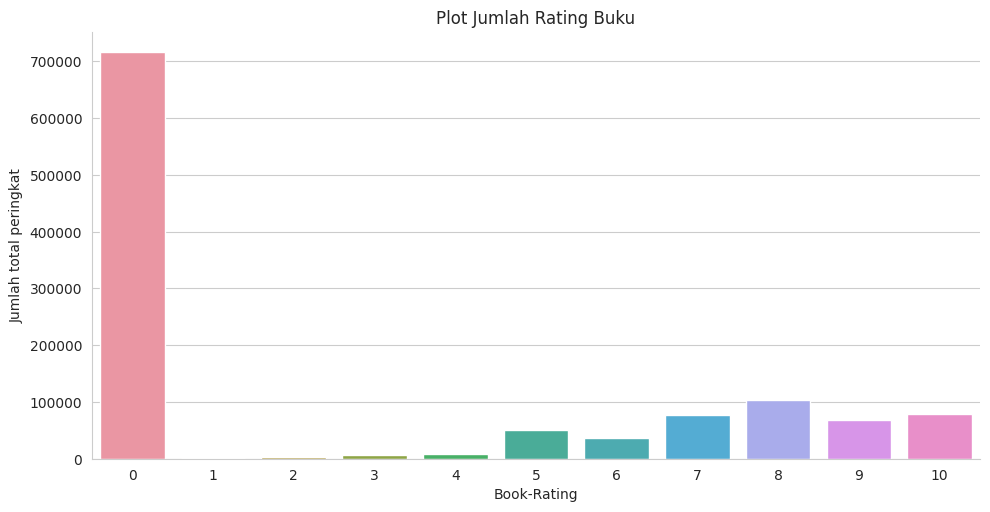

In [ ]:
# plot
with sns.axes_style('whitegrid'):
    g = sns.catplot(x="Book-Rating", data=ratings_dataframe, aspect=2.0, kind='count')
    g.set_ylabels("Jumlah total peringkat")
    plt.title("Plot Jumlah Rating Buku")

# Menampilkan tgrafik
plt.show()

Rating 0 adalah rating buku terbanyak, yaitu sebanyak 700.000 an. Artinya ada banyak buku yang belum dikasih rating, akibatnya bias bisa terjadi dan akan mempengaruhi hasil analisis nantinya. Salah satu solusinya data rating 0 tersebut dapat dihapus pada tahap *data preparation* nanti.

### Dataset User

In [ ]:
users_dataframe

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


Pada atribut Age terdapat nilai NaN (Not a Number), perlu dilakukan pemrosesan lebih lanjutan pada tahap *data preparation* nanti.

In [ ]:
users_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Ternyata NaN pada atribut Age dikarenakan ada missing value

In [ ]:
age_missingvalue = users_dataframe['Age'].isnull().sum()
print('Pada atribut Age terdapat missing value sebanyak', age_missingvalue )

Pada atribut Age terdapat missing value sebanyak 110762


In [ ]:
users_dataframe.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


# 4. Data Preprocessing

Tahap pra-pemrosesan data atau *data preprocessing* merupakan tahap yang perlu diterapkan sebelum melakukan proses pemodelan. Tahap ini adalah teknik yang digunakan untuk mengubah data mentah *(raw data*) menjadi data yang bersih (*clean data*) yang siap untuk digunakan pada proses selanjutnya. Dalam kasus ini, tahap *data preprocessing* dilakukan dengan menyesuaikan nama kolom atau atribut masing-masing *dataframe*, melakukan penggabungkan data ISBN, dan data *User* untuk melihat jumlah data secara keseluruhan.

In [ ]:
# memperbaiki nama atribut books_dataframe
books_dataframe.rename(columns={
    'ISBN'                : 'isbn',
    'Book-Title'          : 'book_title',
    'Book-Author'         : 'book_author',
    'Year-Of-Publication' : 'pub_year',
    'Publisher'           : 'publisher',
    'Image-URL-S'         : 'image_s_url',
    'Image-URL-M'         : 'image_m_url',
    'Image-URL-L'         : 'image_l_url'
}, inplace=True)

books_dataframe.head(3)

,isbn,book_title,book_author,pub_year,publisher,image_s_url,image_m_url,image_l_url
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


In [ ]:
# memperbaiki nama atribut ratings_dataframe
ratings_dataframe.rename(columns={
    'User-ID'     : 'user_id',
    'ISBN'        : 'isbn',
    'Book-Rating' : 'book_rating'
}, inplace=True)

ratings_dataframe.head(3)

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [ ]:
# memperbaiki nama atribut users_dataframe
users_dataframe.rename(columns={
    'User-ID'  : 'user_id',
    'Location' : 'location',
    'Age'      : 'age'
}, inplace=True)

users_dataframe.head(3)

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


In [ ]:
# menggabungkan data ISBN
ISBNAll = np.concatenate((
    books_dataframe.isbn.unique(),
    ratings_dataframe.isbn.unique()
))

ISBNAll = np.sort(np.unique(ISBNAll))

print(f'Jumlah Buku berdasarkan ISBN : {len(ISBNAll)}')

Jumlah Buku berdasarkan ISBN : 341765


In [ ]:
# menggabungkan data user
UserAll = np.concatenate((
    ratings_dataframe.user_id.unique(),
    users_dataframe.user_id.unique()
))

UserAll = np.sort(np.unique(UserAll))

print(f'Jumlah Buku berdasarkan ISBN : {len(UserAll)}')

Jumlah Buku berdasarkan ISBN : 278858


# 5. Data Preparation

### Missmatch Value Handling

In [ ]:
# cek in books
books_dataframe.isnull().sum()

isbn           0
book_title     0
book_author    1
pub_year       0
publisher      2
image_s_url    0
image_m_url    0
image_l_url    3
dtype: int64

Terdapat missing value pada atribut `book_author`, `publisher`, dan `image_l_url` dikarenakan jumlah data yang missing sedikit jika dibandingkan dengan total keseluruhan data, tidak masalah jika kita drop saja bagian data yang kosong atau *null* tersebut.

In [ ]:
# drop data books yang kosong
books = books_dataframe.dropna()

# cek kembali
books.isnull().sum()

isbn           0
book_title     0
book_author    0
pub_year       0
publisher      0
image_s_url    0
image_m_url    0
image_l_url    0
dtype: int64

In [ ]:
# cek in ratings
ratings_dataframe.isnull().sum()

user_id        0
isbn           0
book_rating    0
dtype: int64

Pada dataframe `ratings` tidak ada nilai kosong atau *null* di setiap atributnya.

Pada data understanding telah disinggung melalui grafik histogram **Jumlah Rating Buku**, sebagian besar data rating buku adalah rating 0. Jika dibiarkan bisa mengakibatkan *bias data* pada saat membuat rekomendasi nantinya. Harusnya rating yang dipakai rating 1 sampai rating 10 saja. Sehingga salah satu solusinya data rating 0 tersebut dihapus. Atau bisa cukup di filter saja lalu di *assign* ke variabel lain.

In [ ]:
# ambil rating 1 sampai 10 saja
ratings = ratings_dataframe[ratings_dataframe.book_rating>0]

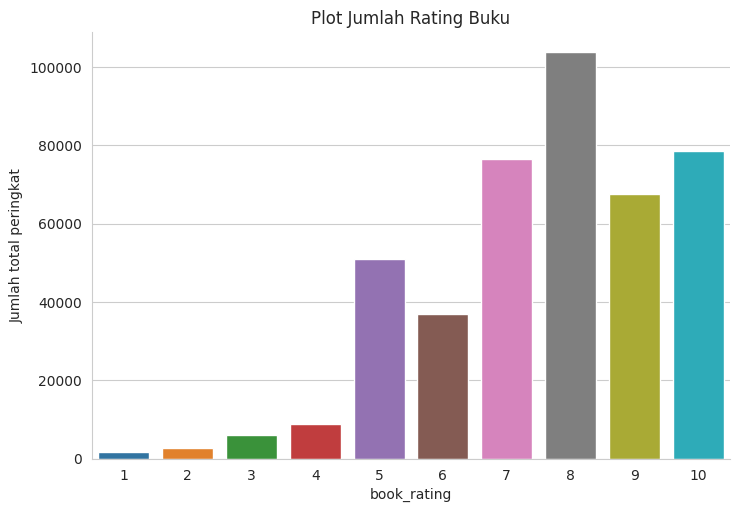

In [ ]:
# plot
with sns.axes_style('whitegrid'):
    g = sns.catplot(x="book_rating", data=ratings, aspect=1.5, kind='count')
    g.set_ylabels("Jumlah total peringkat")
    plt.title("Plot Jumlah Rating Buku")

# Menampilkan tgrafik
plt.show()

Rating 1-10 berhasil di filter.

### Missing value Handling

In [ ]:
# cek in users
users_dataframe.isnull().sum()

user_id          0
location         0
age         110762
dtype: int64

In [ ]:
users_dataframe['age']

0          NaN
1         18.0
2          NaN
3         17.0
4          NaN
          ... 
278853     NaN
278854    50.0
278855     NaN
278856     NaN
278857     NaN
Name: age, Length: 278858, dtype: float64

In [ ]:
(110762/278858)*100

39.71985741847105

Sebelumnya juga telah disinggung tampak seperti diatas terdapat nilai kosong pada *atribut* `age` sebanyak 110.762. Data yang kosong tersebut hampir 40% nya

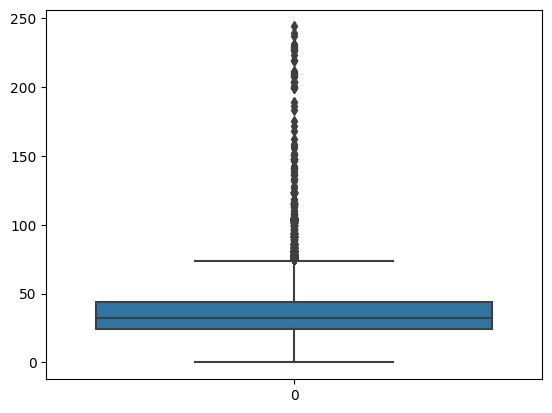

In [ ]:
fig = plt.figure()
ax = sns.boxplot(data =  users_dataframe['age'])
plt.show()

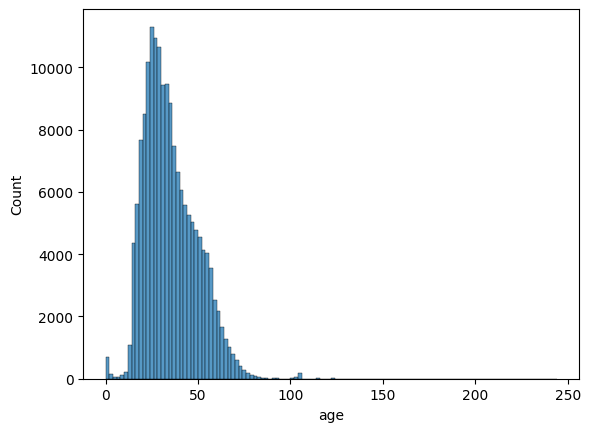

In [ ]:
fig = plt.figure()
ax = sns.histplot(data = users_dataframe['age'], binwidth = 2)
plt.show()



Juga tampak distribusi data miring atau mengandung outliers (banyak orang muda dan beberapa orang tua), sehingga lebih baik data kosong diganti dengan meannya karena selain mencegah kehilangan banyak informasi, merupakan variabel numerik, juga mean lebih dapat mentoleran data miring. Walaupun sebenarnya nantinya hal ini bisa mengakibatkan bias data, but i think it's good idea for now.

In [ ]:
# isi NaN pada age dengan meannya
users = users_dataframe.copy()
users['age'] = users['age'].fillna(users['age'].mean())

In [ ]:
users.isnull().sum()

user_id     0
location    0
age         0
dtype: int64

Nah, nilai `age` yang kosong telah berhasil diganti dengan `median`.

### Data Duplicate Handling

In [ ]:
# cek books
books.duplicated().sum()

0

In [ ]:
# cek ratings
ratings.duplicated().sum()

0

In [ ]:
# cek users
users.duplicated().sum()

0

Berdasarkan hasil kode diatas, tidak ditemukan adanya data duplikat.

Oke sekarang sepertinya data sudah aman, dan saatnya kita gabungkan data books dan ratings

In [ ]:
# gabungkan books dan ratings on key isbn
books_ratings = pd.merge(ratings, books, on=['isbn'])
books_ratings.head()

,user_id,isbn,book_rating,book_title,book_author,pub_year,publisher,image_s_url,image_m_url,image_l_url
0,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
3,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...
4,11676,038550120X,10,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...


# 6. Modelling

Sebelum memulai *modelling*, jika kita perhatikan pada saat *data preprocessing* jumlah data terbilang cukup banyak sampai ratus ribuan dan jika ditotal bisa sampai jutaan. Hal ini tentu bisa memperlambat proses pembuatan model dikarenakan perlu waktu maupun biaya yang lebih untuk menyediakan *RAM*  atau *GPU* yang lebih besar. Oleh karena itu, data yang dipakai hanya 10.000 baris data buku dan 10.000 baris data rating.

In [ ]:
# ambil 10000 books pertama dan 5000 ratings pertama
books   = books[:10000]
ratings = ratings[:10000]

## Content-based Recommendation

Merekomendasikan item yang mirip dengan item yang disukai pengguna di masa lalu. *Content-based filtering* akan mempelajari profil minat pengguna baru berdasarkan data dari objek yang telah dinilai pengguna.

#### TF-IDF Vectorizer

In [ ]:
# Inisialisasi TfidfVectorizer
tfv = TfidfVectorizer()
# Melakukan perhitungan idf pada data cuisine
tfv.fit(books['book_author'])

TfidfVectorizer()

Selanjutnya, melakukan fit dan transformasi atribut book yaitu `book_author` ke dalam bentuk matriks.

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfv.fit_transform(books['book_author'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(10000, 5575)

Matriks yang kita miliki berukuran (10000, 5575). Nilai 10.000 merupakan ukuran data buku dan 5575 merupakan matrik data *author*.

Untuk menghasilkan vektor tf-idf dalam bentuk matriks, kita menggunakan fungsi  [`todense()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.todense.html)

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Selanjutnya, mari kita lihat matriks tf-idf nya

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan author
# Baris diisi dengan nama buku

pd.DataFrame(
    tfidf_matrix.todense(),
    columns = tfv.get_feature_names_out(),
    index   = books.book_title
).sample(20, axis=1).sample(10, axis=0)

,diestler,hanh,goldman,botho,isabel,stahlkuppe,remarque,mary,welsing,brien,risa,scieszka,natalia,dobyns,colleen,lurlene,molly,miriam,dick,cait
book_title,,,,,,,,,,,,,,,,,,,,
The Cat Who Knew Shakespeare,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sugar Busters! (Sugar Busters!),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UN Viejo Que Leia Novelas De Amor/the Old Men Who Read Love Stories (ColecciÃ³n Andanzas),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The GOLDEN CHANCE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"The Burning Time (Shadowrun, 40)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Imaginary Lands,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"The Seeing Stone (The Spiderwick Chronicles, Book 2)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cover Letters That Will Get You the Job You Want,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Die Provencalin. Sonderausgabe.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Cosine Similiarity

Selanjutnya, kita akan menghitung derajat kesamaan (*similarity degree*) antar judul buku dengan teknik *cosine similarity* menggunakan fungsi [`cosine_similarity`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html 'cosine_similarity - scikit-learn Documentation') dari library `sklearn`.

In [ ]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Selanjutnya, mari kita lihat array *cosine similiarity* nya

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama buku
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    columns=books['book_title'],
    index=books['book_title']
)

print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap nama buku
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (10000, 10000)


book_title,Met by Moonlight,Murder at the Library of Congress (Capital Crimes (Paperback)),Warm Worlds and Otherwise,Situation Ethics: The New Morality,The Letter of the Law
book_title,,,,,
Clifford's Sports Day,0.0,0.0,0.000000,0.000000,0.0
Golden Orange,0.0,0.0,0.000000,0.328568,0.0
A Gift of Wings,0.0,0.0,0.000000,0.000000,0.0
Moonlight Becomes You,0.0,0.0,0.000000,0.000000,0.0
The Hunt for Red October,0.0,0.0,0.000000,0.000000,0.0
Matilda,0.0,0.0,0.000000,0.000000,0.0
The Thief of Always,0.0,0.0,0.000000,0.000000,0.0
Puerto Vallarta Squeeze,0.0,0.0,0.192036,0.000000,0.0
Alec Baldwin Doesn't Love Me and Other Trials of My Queer Life,0.0,0.0,0.000000,0.000000,0.0


#### Recommendation Testing

In [ ]:
cosine_sim_df

book_title,Classical Mythology,Clara Callan,Decision in Normandy,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,The Mummies of Urumchi,The Kitchen God's Wife,What If?: The World's Foremost Military Historians Imagine What Might Have Been,PLEADING GUILTY,Under the Black Flag: The Romance and the Reality of Life Among the Pirates,Where You'll Find Me: And Other Stories,...,Kaplan GRE Exam 2004,Around the World in Eighty Days (Tor Classics),The Exploits of the Incomparable Mulla Nasrudin / The Subtleties of the Inimitable Mulla Nasrudin,The Hours : A Novel,Beloved (Penguin Great Books of the 20th Century),Read This and Tell Me What It Says : Stories (Bard Book),The Star Rover,Die Keltennadel.,Tod in der Datscha.,Dunkel.
book_title,,,,,,,,,,,,,,,,,,,,,
Classical Mythology,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Clara Callan,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Decision in Normandy,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Mummies of Urumchi,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Read This and Tell Me What It Says : Stories (Bard Book),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
The Star Rover,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Die Keltennadel.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Membuat fungsi `author_recommendations` untuk menampilkan data buku yang direkomendasikan oleh algoritma sistem yang telah dibuat, dengan parameter masukan berupa `book_title` yang sudah pernah dibaca oleh *user*.

In [ ]:
def author_recommendations(book_title, similarity_data=cosine_sim_df, items=books[['book_title', 'book_author']], k=10):
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,book_title].to_numpy().argpartition(range(-1, -k, -1))
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    # Drop nama buku agar nama buku yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(book_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
books['book_title']

0                                     Classical Mythology
1                                            Clara Callan
2                                    Decision in Normandy
3       Flu: The Story of the Great Influenza Pandemic...
4                                  The Mummies of Urumchi
                              ...                        
9995    Read This and Tell Me What It Says : Stories (...
9996                                       The Star Rover
9997                                     Die Keltennadel.
9998                                  Tod in der Datscha.
9999                                              Dunkel.
Name: book_title, Length: 10000, dtype: object

Selanjutnya, mari kita terapkan fungsi di atas untuk menemukan rekomendasi buku yang mirip dengan buku  Proxies. Sebelumnya saya cari dulu nama buku yang mau ditest

In [ ]:
readed_book_title ="Adventures of Huckleberry Finn"

In [ ]:
books[books.book_title.eq(readed_book_title)]

,isbn,book_title,book_author,pub_year,publisher,image_s_url,image_m_url,image_l_url
2354,0835902242,Adventures of Huckleberry Finn,Mark Twain,1992,Globe Fearon,http://images.amazon.com/images/P/0835902242.0...,http://images.amazon.com/images/P/0835902242.0...,http://images.amazon.com/images/P/0835902242.0...


In [ ]:
author_recommendations(readed_book_title).drop_duplicates()

,book_title,book_author
0,ADVENTURES OF HUCKLEBERRY FINN (ENRICHED CLASS...,Mark Twain
1,Treasury of Illustrated Classics: Adventures o...,Mark Twain
2,The Complete Short Stories of Mark Twain (Bant...,Mark Twain
3,A Connecticut Yankee in King Arthur's Court (D...,Mark Twain
4,A Connecticut Yankee in King Arthur's Court (B...,Mark Twain
5,The Diaries of Adam and Eve,Mark Twain
6,The Adventures of Tom Sawyer,Mark Twain


Tampak 7 buku (sesuai banyak k) yang direkomendasikan bersesuaian dengan buku *Adventures of Huckleberry Finn*.

Sehingga , akurasi nya 7/10 * 100 = 70%

## Collaborative Filtering Recommendation

We do not want to find a similarity between users or books. we want to do that If there is user A who has read and liked x and y books, And user B has also liked this two books and now user A has read and liked some z book which is not read by B so we have to recommend z book to user B. This is what collaborative filtering is.

Sistem rekomendasi penyaringan kolaboratif (*Collaborative Filtering Recommendation*) adalah sistem rekomendasi yang merekomendasikan item yang mirip dengan preferensi pengguna di masa lalu, misalnya berdasarkan *rating* yang telah diberikan oleh pengguna di masa lalu.

#### Data Preparation

##### Label Encoding

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 25000
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      10000 non-null  int64 
 1   isbn         10000 non-null  object
 2   book_rating  10000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 312.5+ KB


Melakukan *encoding* pada fitur `user_id` dan `isbn` buku kedalam *indeks integer*.

In [ ]:
user_id_enc = ratings.user_id.unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_id_enc)}
user_encoded_to_user = {i: x for i, x in enumerate(user_id_enc)}

In [ ]:
book_id_enc = ratings['isbn'].unique().tolist()
book_to_book_encoded = {x: i for i, x in enumerate(book_id_enc)}
book_encoded_to_book = {i: x for i, x in enumerate(book_id_enc)}

Mapping `user_id` dan `isbn` yang sudah di encode ke dalam *dataframe*.

In [ ]:
ratings

,user_id,isbn,book_rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
24990,5988,0425121259,7
24992,5988,0812507428,7
24997,5990,0061030430,3
24999,5991,070097002249,9


In [ ]:
ratings['user'] = ratings.user_id.map(user_to_user_encoded)
ratings['book'] = ratings.isbn.map(book_to_book_encoded)

<ipython-input-130-fa4381bc2ddc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['user'] = ratings.user_id.map(user_to_user_encoded)
<ipython-input-130-fa4381bc2ddc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['book'] = ratings.isbn.map(book_to_book_encoded)


Cek beberapa hal dalam data seperti jumlah user, jumlah buku, dan rating minimal serta rating maksimal.

In [ ]:
ratings

,user_id,isbn,book_rating,user,book
1,276726,0155061224,5,0,0
3,276729,052165615X,3,1,1
4,276729,0521795028,6,1,2
6,276736,3257224281,8,2,3
7,276737,0600570967,6,3,4
...,...,...,...,...,...
24990,5988,0425121259,7,2244,8786
24992,5988,0812507428,7,2244,8787
24997,5990,0061030430,3,2245,8788
24999,5991,070097002249,9,2246,8789


In [ ]:
num_users = len(user_encoded_to_user)
num_books = len(book_encoded_to_book)

min_ratings = min(ratings.book_rating)
max_ratings = max(ratings.book_rating)

ratings_dataframe['book_rating'] = ratings_dataframe['book_rating'].values.astype(np.float32)

print(num_users)
print(num_books)
print(f'Number of User: {num_users}, Number of Books: {num_books}, Min Rating: {min_ratings}, Max Rating: {max_ratings}')

2248
8791
Number of User: 2248, Number of Books: 8791, Min Rating: 1, Max Rating: 10


#### Training Data and Validation Data Split

Melakukan pembagian data menjadi data training dan validasi. Namun sebelumnya, datanya diacak terlebih dahulu agar distribusinya menjadi random.

In [ ]:
# Mengacak dataset
ratings = ratings.sample(frac=1, random_state=412)
ratings

,user_id,isbn,book_rating,user,book
12016,941,0553258001,9,881,3301
19372,3640,0671004549,5,1630,4480
13927,1933,0440226430,8,1144,1210
12227,1095,3478088534,5,920,3410
13160,1597,0316569321,7,1062,1452
...,...,...,...,...,...
22127,4435,887641083X,10,1859,7655
21928,4385,0446360732,10,1845,7550
12371,1167,038533656X,5,941,3478
23054,5204,2070362388,6,2032,8028


Melakukan pembagian *dataset* dengan rasio 80:20, yaitu 80% untuk data latih (*training data*) dan 20% untuk data uji (*validation data*).

Namun sebelumnya, kita perlu memetakan (mapping) data user dan book menjadi satu value terlebih dahulu. Lalu, buatlah book_rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training.

In [ ]:
# Membuat variabel x untuk mencocokkan data user dan book menjadi satu value
x = ratings[['user', 'book']].values

# Membuat variabel y untuk membuat rating dari hasil
y = ratings['book_rating'].apply(lambda x: (x-min_ratings) / (max_ratings-min_ratings)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * ratings.shape[0])

xTrain, xVal, yTrain, yVal = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 881 3301]
 [1630 4480]
 [1144 1210]
 ...
 [ 941 3478]
 [2032 8028]
 [1801  457]] [0.88888889 0.44444444 0.77777778 ... 0.44444444 0.55555556 0.66666667]


#### Building and Training Process

Pembuatan model akan menggunakan kelas `RecommenderNet` dengan [*keras model class*](https://keras.io/api/models/model 'Model class - Keras Documentation').

In [ ]:
class RecommenderNet(tf.keras.Model):
    # Insialisasi fungsi
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(# layer embedding user
            num_users,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.user_bias      = layers.Embedding(num_users, 1)# layer embedding user bias
        self.book_embedding = layers.Embedding( # layer embeddings book
            num_books,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.book_bias = layers.Embedding(num_books, 1)#layer embedding book bias

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])# memanggil layer embedding 1
        user_bias   = self.user_bias(inputs[:, 0])# memanggil layer embedding 2
        book_vector = self.book_embedding(inputs[:, 1])# memanggil layer embedding 3
        book_bias   = self.book_bias(inputs[:, 1])# memanggil layer embedding 4

        dot_user_book = tf.tensordot(user_vector, book_vector, 2)

        x = dot_user_book + user_bias + book_bias

        return tf.nn.sigmoid(x)# activation sigmoid

Selanjutnya, lakukan proses compile terhadap model.

In [ ]:
model = RecommenderNet(num_users, num_books, 50)

model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss      = BinaryCrossentropy(),
    metrics   = [RootMeanSquaredError()]
)

Model ini menggunakan` Binary Crossentropy` untuk menghitung *loss function*, `Adam (Adaptive Moment Estimation)` sebagai *optimizer*, dan `root mean squared error (RMSE)` sebagai *metrics evaluation*.

Langkah berikutnya, mulailah proses training. Namun sebelumnya saya buatkan fungsi *callback* untuk menghentikan proses training jika metrik evaluasi yaitu `root_mean_squared_error` sudah kurang dari 0.1.

In [ ]:
class RMSECallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold_rmse):
        super().__init__()
        self.threshold_rmse = threshold_rmse

    def on_epoch_end(self, epoch, logs={}):
        current_rmse = logs.get('root_mean_squared_error')
        if current_rmse is not None and current_rmse < self.threshold_rmse:
            print(f"\nRMSE telah mencapai nilai yang cukup rendah (< {self.threshold_rmse})!")
            self.model.stop_training = True

# Contoh penggunaan callback
threshold_rmse = 0.1  # Ganti nilai ambang sesuai kebutuhan Anda
rmse_callback = RMSECallback(threshold_rmse)

Training model

In [ ]:
history = model.fit(
    x               = xTrain,
    y               = yTrain,
    batch_size      = 20,
    epochs          = 70,
    callbacks=[rmse_callback],
    validation_data = (xVal, yVal),
)

Epoch 1/70
400/400 [==============================] - 4s 9ms/step - loss: 0.6849 - root_mean_squared_error: 0.3040 - val_loss: 0.6756 - val_root_mean_squared_error: 0.2970
Epoch 2/70
400/400 [==============================] - 3s 9ms/step - loss: 0.5857 - root_mean_squared_error: 0.2111 - val_loss: 0.6679 - val_root_mean_squared_error: 0.2903
Epoch 3/70
400/400 [==============================] - 4s 10ms/step - loss: 0.5706 - root_mean_squared_error: 0.1949 - val_loss: 0.6682 - val_root_mean_squared_error: 0.2907
Epoch 4/70
400/400 [==============================] - 3s 8ms/step - loss: 0.5621 - root_mean_squared_error: 0.1864 - val_loss: 0.6645 - val_root_mean_squared_error: 0.2875
Epoch 5/70
400/400 [==============================] - 4s 9ms/step - loss: 0.5584 - root_mean_squared_error: 0.1829 - val_loss: 0.6621 - val_root_mean_squared_error: 0.2855
Epoch 6/70
400/400 [==============================] - 5s 13ms/step - loss: 0.5544 - root_mean_squared_error: 0.1785 - val_loss: 0.6595 - va

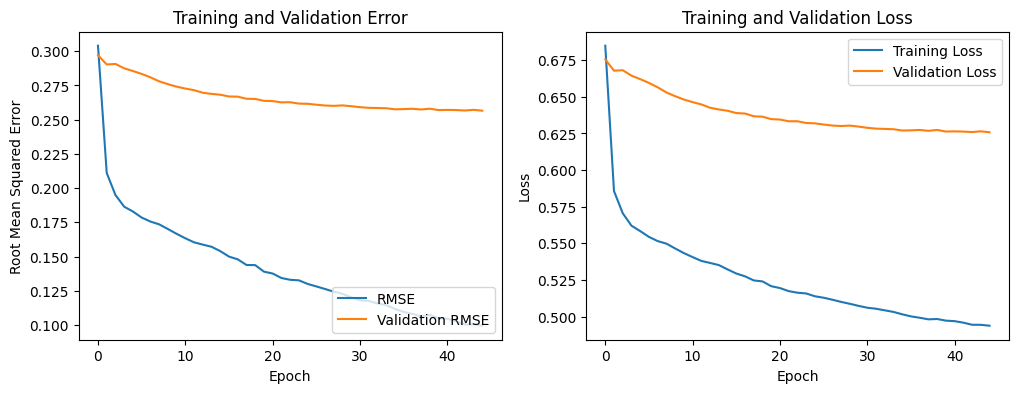

In [ ]:
rmse     = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss     = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(rmse,     label='RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Training and Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(loss,     label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

#### Recommendation Testing

In [ ]:
# Pendefenisian ulang dataset books dan ratings
datasetBook   = books
datasetRating = ratings

**Untuk** mendapatkan rekomendasi buku yang akan dihasilkan oleh sistem, diperlukan sebuah data atau sampel dari pengguna secara acak dan mendefinisikan variabel buku yang belum pernah dibaca oleh pengguna atau `notReadedBooks` yang merupakan daftar buku yang nantinya akan direkomendasikan. Daftar tersebut dapat didapatkan dengan menggunakan operator logika bitwise ([`~`](https://docs.python.org/3/reference/expressions.html#unary-arithmetic-and-bitwise-operations 'Unary Arithmetic and Bitwise Operations - Python Documentation')) pada variabel buku yang telah dibaca oleh pengguna atau`readedBooks`.

In [ ]:
userId = datasetRating.user_id.sample(1).iloc[0]
readedBooks = datasetRating[datasetRating.user_id == userId]

notReadedBooks = datasetBook[~datasetBook['isbn'].isin(readedBooks.isbn.values)]['isbn']
notReadedBooks = list(
    set(notReadedBooks).intersection(set(book_to_book_encoded.keys()))
)

notReadedBooks = [[book_to_book_encoded.get(x)] for x in notReadedBooks]
userEncoder    = user_to_user_encoded.get(userId)
userBookArray = np.hstack(
    ([[userEncoder]] * len(notReadedBooks), notReadedBooks)
)

Selanjutnya, untuk memperoleh rekomendasi buku, gunakan fungsi  [`model.predict()`](https://keras.io/api/models/model/) dari library Keras dengan menerapkan kode berikut.

In [ ]:
ratings = model.predict(userBookArray).flatten()

topRatingsIndices   = ratings.argsort()[-10:][::-1]
recommendedBookIds = [
    book_encoded_to_book.get(notReadedBooks[x][0]) for x in topRatingsIndices
]

print('Showing recommendations for users: {}'.format(userId))
print('=====' * 8)
print('Book with high ratings from user')
print('-----' * 8)

topBookUser = (
    readedBooks.sort_values(
        by = 'book_rating',
        ascending=False
    )
    .head(5)
    .isbn.values
)

bookDfRows = datasetBook[datasetBook['isbn'].isin(topBookUser)]
for row in bookDfRows.itertuples():
    print(row.book_title, ':', row.book_author)

print('=====' * 8)
print('Top 10 Books Recommendation')
print('-----' * 8)

recommended_resto = datasetBook[datasetBook['isbn'].isin(recommendedBookIds)]
for row in recommended_resto.itertuples():
    print(row.book_title, ':', row.book_author)

128/128 [==============================] - 0s 2ms/step
Showing recommendations for users: 5709
Book with high ratings from user
----------------------------------------
All-American Girl : Meg Cabot
New York Minute : The Movie Novelization (New York Minute) : Mary-Kate &amp; Ashley Olsen
CHOCOLATE FOR A WOMANS SOUL : 77 STORIES TO FEED YOUR SPIRIT AND WARM YOUR HEART (Chocolate) : Kay Allenbaugh
Coraline : Neil Gaiman
Mates, Dates, and Sleepover Secrets (Mates, Dates) : Cathy Hopkins
Top 10 Books Recommendation
----------------------------------------
To Kill a Mockingbird : Harper Lee
The Red Tent (Bestselling Backlist) : Anita Diamant
The Giver (21st Century Reference) : LOIS LOWRY
The Grapes of Wrath: John Steinbeck Centennial Edition (1902-2002) : John Steinbeck
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) : J. K. Rowling
My Lady Pirate : Elizabeth Doyle
The Runaway Jury : JOHN GRISHAM
Daughter of the Blood (Black Jewels Trilogy) : Anne Bishop
The Watsons Go to 

# 7. Kesimpulan